In [112]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [113]:
data8 = pd.read_csv('C:/Users/daini/OneDrive/Dators/ai/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')

In [114]:
data_combined = data8

# Izvadām datu dimensiju
rows, cols = data_combined.shape
print(f'Number of rows: {rows}, Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

# Noņemam liekās atstarpes no kolonnu nosaukumiem
col_names = {col: col.strip() for col in data_combined.columns}
data_combined.rename(columns = col_names, inplace = True)

data_combined.columns

Number of rows: 692703, Number of columns: 79
Total cells: 54723537


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [115]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             692703 non-null  int64  
 1   Flow Duration                692703 non-null  int64  
 2   Total Fwd Packets            692703 non-null  int64  
 3   Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets  692703 non-null  int64  
 5   Total Length of Bwd Packets  692703 non-null  int64  
 6   Fwd Packet Length Max        692703 non-null  int64  
 7   Fwd Packet Length Min        692703 non-null  int64  
 8   Fwd Packet Length Mean       692703 non-null  float64
 9   Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max        692703 non-null  int64  
 11  Bwd Packet Length Min        692703 non-null  int64  
 12  Bwd Packet Length Mean       692703 non-null  float64
 13 

In [116]:
# Daru tīrīšana
# Dublētu vērtību identificēšana
dups = data_combined[data_combined.duplicated()]
print(f'Dublikātu skaits: {len(dups)}')

Dublikātu skaits: 81909


In [117]:
# Noņemam visus dubultos ierakstus
data_combined.drop_duplicates(inplace = True)
data_combined.shape

(610794, 79)

In [118]:
# Trūkstošo vērtību noteikšana
missing_val = data_combined.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    61
dtype: int64


In [119]:
# Bezgalības vērtību pārbaude
numeric_cols = data_combined.select_dtypes(include = np.number).columns
inf_count = np.isinf(data_combined[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      241
Flow Packets/s    302
dtype: int64


In [120]:
# Jebkuru bezgalīgu vērtību (pozitīvu vai negatīvu) aizstāšana ar NaN (nevis skaitli)
print(f'Trūkstošās vērtības: {data_combined.isna().sum().sum()}')

data_combined.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: {data_combined.isna().sum().sum()}')

Trūkstošās vērtības: 61
Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: 604


In [121]:
# Identificējam un saskaitītām trūkstošās vērtības
missing = data_combined.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      302
Flow Packets/s    302
dtype: int64


In [122]:
# Trūkstošo vērtību procentuālās daļas aprēķināšana
mis_per = (missing / len(data_combined)) * 100
print(mis_per[mis_per > 0].round(2))

Flow Bytes/s      0.05
Flow Packets/s    0.05
dtype: float64


In [123]:
# Mediānas noteikšana
med_flow_bytes = data_combined['Flow Bytes/s'].median()
med_flow_packets = data_combined['Flow Packets/s'].median()

# Trūkstošo vērtību aizpildīšana ar mediānu
data_combined['Flow Bytes/s'] = data_combined['Flow Bytes/s'].fillna(med_flow_bytes)
data_combined['Flow Packets/s'] = data_combined['Flow Packets/s'].fillna(med_flow_packets)

print('Trūkstošo \'Flow Bytes/s\' vērtību skaits:', data_combined['Flow Bytes/s'].isna().sum())
print('Trūkstošo \'Flow Packets/s\' vērtību skaits:', data_combined['Flow Packets/s'].isna().sum())

Trūkstošo 'Flow Bytes/s' vērtību skaits: 0
Trūkstošo 'Flow Packets/s' vērtību skaits: 0


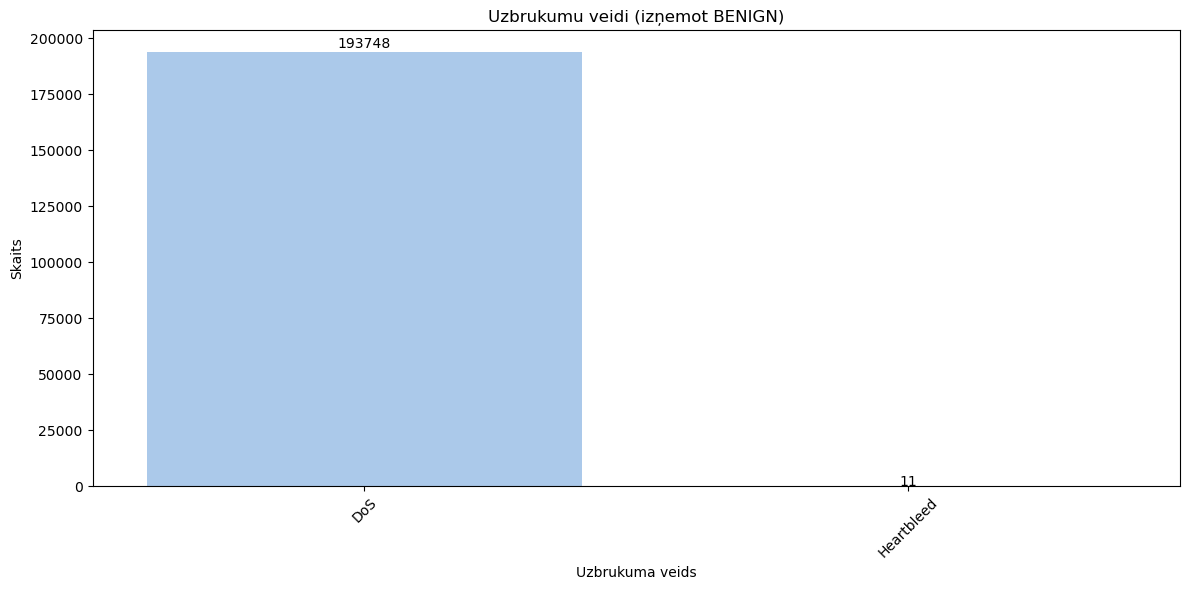

In [124]:
# Izveidojam vārdnīcu, kurā katra uzbrukuma veidi tiek sagrupēti kategorijās
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'Heartbleed': 'Heartbleed'
}

# "Attack Type" definēšana
data_combined['Attack Type'] = data_combined['Label'].map(attack_map)

import matplotlib.pyplot as plt
import seaborn as sns

# Izmantojam visus izņemot "BENIGN"
attacks = data_combined.loc[data_combined['Attack Type'] != 'BENIGN']

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='Attack Type',
    hue='Attack Type',
    data=attacks,
    palette='pastel',
    order=attacks['Attack Type'].value_counts().index,
    legend=False
)
plt.title('Uzbrukumu veidi (izņemot BENIGN)')
plt.xlabel('Uzbrukuma veids')
plt.ylabel('Skaits')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.01), ha='center')

plt.tight_layout()
plt.show()

In [125]:
# Atdalām iezīmes (X) un mērķa mainīgo (y)
X = data_combined.drop(['Label', 'Attack Type'], axis=1)
y = data_combined['Label']

# Sadalām datus treniņu un testēšanas kopās (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standartizējam datu iezīmes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
from sklearn.tree import DecisionTreeClassifier
# Apmāca Decision Tree modeli
dt = DecisionTreeClassifier(max_depth=6)
t0 = time()
dt.fit(X_train, y_train)
tt0 = time() - t0
print ("Klasifikators tika apmācīts {} sekundēs.".format(round(tt0, 3)))

t1 = time()
# Paredz rezultātus uz testu datiem
y_pred_dt = dt.predict(X_test)
tt1 = time() - t1
print ("Prognoze tika iegūta {} sekundēs.".format(round(tt1,3)))
# Novērtē precizitāti
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Izvada rezultātu
print('Lēmumu koka modelis')
print(f'Accuracy on test set: {accuracy_dt:.10f}')

Klasifikators tika apmācīts 6.454 sekundēs.
Prognoze tika iegūta 0.041 sekundēs.
Lēmumu koka modelis
Accuracy on test set: 0.9854343235


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# Apmāca modeli
t2 = time()
knn.fit(X_train, y_train)
tt2 = time() - t2
print("Klasifikators tika apmācīts {} sekundēs.".format(round(tt2, 3)))

# Paredz rezultātus uz testu datiem
t3 = time()
y_pred_knn = knn.predict(X_test)
tt3 = time() - t3
print("Prognoze tika iegūta {} sekundēs.".format(round(tt3, 3)))

# Novērtē precizitāti
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Izvada rezultātu
print('KNN modelis')
print(f'Accuracy on test set: {accuracy_knn:.10f}')

Klasifikators tika apmācīts 0.505 sekundēs.


In [ ]:
from sklearn.naive_bayes import GaussianNB
# Apmāca Gaussian Naive Bayes modeli
gnb = GaussianNB()
t5 = time()
gnb.fit(X_train, y_train)
tt5 = time() - t5
print("Klasifikators tika apmācīts {} sekundēs.".format(round(tt5, 3)))

# Paredz rezultātus uz testu datiem
t6 = time()
y_pred_gnb = gnb.predict(X_test)
tt6 = time() - t6
print("Prognoze tika iegūta {} sekundēs.".format(round(tt6, 3)))

# Novērtē precizitāti
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print('Naive Bayes modelis')
print(f'Accuracy on test set: {accuracy_gnb:.10f}')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm_dt = confusion_matrix(y_test, y_pred_dt)
unique_labels = sorted(data_combined['Label'].unique())

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=unique_labels)
disp_dt.plot(cmap='Blues')
plt.xticks(rotation=90)
plt.title('Confusion Matrix – Decision Tree')
plt.show()

In [ ]:
# Iegūstam un sakārtojam unikālās iezīmju (Label) vērtības no datiem
cm_knn = confusion_matrix(y_test, y_pred_knn)
unique_labels = sorted(data_combined['Label'].unique())

disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=unique_labels)
disp_knn.plot(cmap='Blues')
plt.xticks(rotation=90)
plt.title('Confusion Matrix – K-Nearest Neighbors')
plt.show()

In [ ]:
# Iegūstam un sakārtojam unikālās etiķetes
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
unique_labels = sorted(data_combined['Label'].unique())

disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=unique_labels)
disp_gnb.plot(cmap='Blues')
plt.xticks(rotation=90)
plt.title('Confusion Matrix – Gaussian Naive Bayes')
plt.show()

In [ ]:
# Izvada detalizētu pārskatu par modeļu precizitāti
print("Decision Tree – Classification Report")
print(classification_report(y_test, y_pred_dt, target_names=unique_labels))

In [ ]:
print("K-Nearest Neighbors – Classification Report")
print(classification_report(y_test, y_pred_knn, target_names=unique_labels))

In [ ]:
print("Naive Bayes – Classification Report")
print(classification_report(y_test, y_pred_gnb, target_names=unique_labels))

In [ ]:
print("Model Comparison")
print("-------------------------------")
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"KNN Accuracy:           {accuracy_knn:.4f}")
print(f"Naive Bayes Accuracy:   {accuracy_gnb:.4f}")